# Loan_prediction

## Problem 

- A Company wants to automate the loan eligibility process based on customer details provided while filling online application form.

## Data source
- Source: Datahack
https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

In [39]:
# Importing the required library
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import svm

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
ler = LabelEncoder()
sc = StandardScaler()

### Visualizing the dataset

In [4]:
# Reading the training dataset
train_df = pd.read_csv("train_data.csv")

# Reading the test dataset
test_df = pd.read_csv("test_data.csv")

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
test_df.head(10)
# NAN can be observed in some of the coulmns, meaning the test data would also require data cleaning.

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
5,LP001054,Male,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban
6,LP001055,Female,No,1,Not Graduate,No,2226,0,59.0,360.0,1.0,Semiurban
7,LP001056,Male,Yes,2,Not Graduate,No,3881,0,147.0,360.0,0.0,Rural
8,LP001059,Male,Yes,2,Graduate,NaN,13633,0,280.0,240.0,1.0,Urban
9,LP001067,Male,No,0,Not Graduate,No,2400,2400,123.0,360.0,1.0,Semiurban


##### Considering the volume of the data, quick analysis and visualization of the dataset can be carried out using Exploratory data analysis tool (EDA). I'll be using pandas profilling

In [7]:
# Quick analysis and data viz using Pandas Profiling
train_report = ProfileReport(train_df)
train_report.to_file(output_file="train_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Quick analysis and data viz using Pandas Profiling
test_report = ProfileReport(test_df)
test_report.to_file(output_file="test_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Data processing

In [9]:
def firstlook(column_name):
    print("Training data's unique " + column_name + ": ", train_df[column_name].unique())
    print("Test data's unique " + column_name + ": ", test_df[column_name].unique())
    print('\n\nTraining data:')
    return train_df[column_name].value_counts()

In [10]:
# checking missing values in each column
train_df.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

##### Gender

In [11]:
Gender_df = firstlook('Gender')
Gender_df

Training data's unique Gender:  ['Male' 'Female' nan]
Test data's unique Gender:  ['Male' 'Female' nan]


Training data:


Male      489
Female    112
Name: Gender, dtype: int64

In [12]:
# Assigning Male to the null values
train_df.Gender = train_df.Gender.fillna('Male')
test_df.Gender = train_df.Gender.fillna('Male')

#####  Married

In [13]:
Married_df = firstlook('Married')
Married_df

Training data's unique Married:  ['No' 'Yes' nan]
Test data's unique Married:  ['Yes' 'No']


Training data:


Yes    398
No     213
Name: Married, dtype: int64

In [14]:
train_df[train_df['Married'].isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,LP001357,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,LP001760,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


In [15]:
# Specified person 104 as 'married' because he had coapplicant and 'single' for others 
train_df['Married'][104] = 'Yes'
train_df.Married = train_df.Married.fillna('No')

C:\Users\busola\AppData\Local\Temp/ipykernel_428/4149492815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Married'][104] = 'Yes'


##### Dependents

In [16]:
Dependent_df = firstlook('Dependents')
Dependent_df

Training data's unique Dependents:  ['0' '1' '2' '3+' nan]
Test data's unique Dependents:  ['0' '1' '2' '3+' nan]


Training data:


0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [17]:
train_df[train_df['Dependents'].isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
102,LP001350,Male,Yes,NaN,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
104,LP001357,Male,Yes,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
120,LP001426,Male,Yes,NaN,Graduate,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
226,LP001754,Male,Yes,NaN,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
228,LP001760,Male,No,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
293,LP001945,Female,No,NaN,Graduate,No,5417,0.0,143.0,480.0,0.0,Urban,N
301,LP001972,Male,Yes,NaN,Not Graduate,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y
332,LP002100,Male,No,NaN,Graduate,No,2833,0.0,71.0,360.0,1.0,Urban,Y
335,LP002106,Male,Yes,NaN,Graduate,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y
346,LP002130,Male,Yes,NaN,Not Graduate,No,3523,3230.0,152.0,360.0,0.0,Rural,N


In [18]:
# Training data
# Filling the null values with 1 and zero based on the values in the Married column
train_df['Dependents'] = np.where((train_df['Married'] == 'Yes') & (train_df['Dependents'].isnull()), 1, train_df['Dependents'])
train_df['Dependents'] = np.where((train_df['Married'] == 'No') & (train_df['Dependents'].isnull()), 0, train_df['Dependents'])

# Changing the value '3+' to 3
train_df['Dependents'] = np.where((train_df['Dependents'] == '3+'), 3, train_df['Dependents'])

# Changing the data type to integer
train_df['Dependents'] = pd.to_numeric(train_df['Dependents'], errors='coerce')

train_df['Dependents'].unique()

array([0, 1, 2, 3], dtype=int64)

In [19]:
# Test data
# Filling the null values with 1 and zero based on the values in the Married column
test_df['Dependents'] = np.where((test_df['Married'] == 'Yes') & (test_df['Dependents'].isnull()), 1, test_df['Dependents'])
test_df['Dependents'] = np.where((test_df['Married'] == 'No') & (test_df['Dependents'].isnull()), 0, test_df['Dependents'])

# Changing the value '3+' to 3
test_df['Dependents'] = np.where((test_df['Dependents'] == '3+'), 3, test_df['Dependents'])

# Changing the data type to integer
test_df['Dependents'] = pd.to_numeric(test_df['Dependents'], errors='coerce')

test_df['Dependents'].unique()

array([0, 1, 2, 3], dtype=int64)

##### Self_Employed

In [20]:
Self_Employed_df = firstlook('Self_Employed')
Self_Employed_df

Training data's unique Self_Employed:  ['No' 'Yes' nan]
Test data's unique Self_Employed:  ['No' 'Yes' nan]


Training data:


No     500
Yes     82
Name: Self_Employed, dtype: int64

In [21]:
train_df['Self_Employed'] = train_df['Self_Employed'].fillna('No')
test_df['Self_Employed'] = test_df['Self_Employed'].fillna('No')

##### LoanAmount

In [22]:
train_df['LoanAmount'] = train_df['LoanAmount'].fillna(train_df['LoanAmount'].mean())
test_df['LoanAmount'] = test_df['LoanAmount'].fillna(test_df['LoanAmount'].mean())

##### Loan_Amount_Term

In [23]:
Loan_Amount_Term_df = firstlook('Loan_Amount_Term')
Loan_Amount_Term_df

Training data's unique Loan_Amount_Term:  [360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]
Test data's unique Loan_Amount_Term:  [360. 240. 180.  nan  60. 480.  84.  12. 300. 350.  36. 120.   6.]


Training data:


360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [24]:
train_df['Loan_Amount_Term'] = train_df['Loan_Amount_Term'].fillna(360.0)
test_df['Loan_Amount_Term'] = test_df['Loan_Amount_Term'].fillna(360.0)

##### Credit_History

In [25]:
Credit_History_df = firstlook('Credit_History')
Credit_History_df

Training data's unique Credit_History:  [ 1.  0. nan]
Test data's unique Credit_History:  [ 1. nan  0.]


Training data:


1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [26]:
# In the absence of an explanation for the nulls, a zero value was assigned to the nulls to 
# represent no information was found about the client's credit history 
train_df['Credit_History'] = train_df['Credit_History'].fillna(0.0)
test_df['Credit_History'] = test_df['Credit_History'].fillna(0.0)

In [27]:
train_df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.000000,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.000000,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3,Graduate,No,3036,2504.0,158.000000,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.000000,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.000000,360.0,1.0,Semiurban,N


In [28]:
copy_train_df = train_df
copy_test_df = test_df
copy_train_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

### Understanding the features and their relevance in target prediction

In [29]:
# Extracting the training features
full_data = copy_train_df.drop(columns=['Loan_ID'], inplace=False)
train_data = copy_train_df.drop(columns=['Loan_ID', 'Loan_Status'], inplace=False)
train_target = copy_train_df.pop('Loan_Status')

# Extracting the test features
test_data = copy_test_df.drop(columns=['Loan_ID'], inplace=False)

# Encoding the Independent Variable
from sklearn.preprocessing import LabelEncoder
ler = LabelEncoder()

col_names = full_data.columns
category_index = [0,1,3,4,10,11]
# Drop the first and last column 
for ind in category_index:
    full_data[col_names[ind]] = ler.fit_transform(full_data[col_names[ind]])
    
y_target = ler.fit_transform(train_target)

full_data.head(10)
# Encoding for training
#labelencoder_y = LabelEncoder()

#X_train[:,10] = labelencoder_X.fit_transform(X_train[:,10])
#y_train = labelencoder_y.fit_transform(y_train)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1
5,1,1,2,0,1,5417,4196.0,267.000000,360.0,1.0,2,1
6,1,1,0,1,0,2333,1516.0,95.000000,360.0,1.0,2,1
7,1,1,3,0,0,3036,2504.0,158.000000,360.0,0.0,1,0
8,1,1,2,0,0,4006,1526.0,168.000000,360.0,1.0,2,1
9,1,1,1,0,0,12841,10968.0,349.000000,360.0,1.0,1,0


In [30]:
#Introduce new feature
full_data['TotalIncome'] = full_data['ApplicantIncome'] + full_data['CoapplicantIncome']

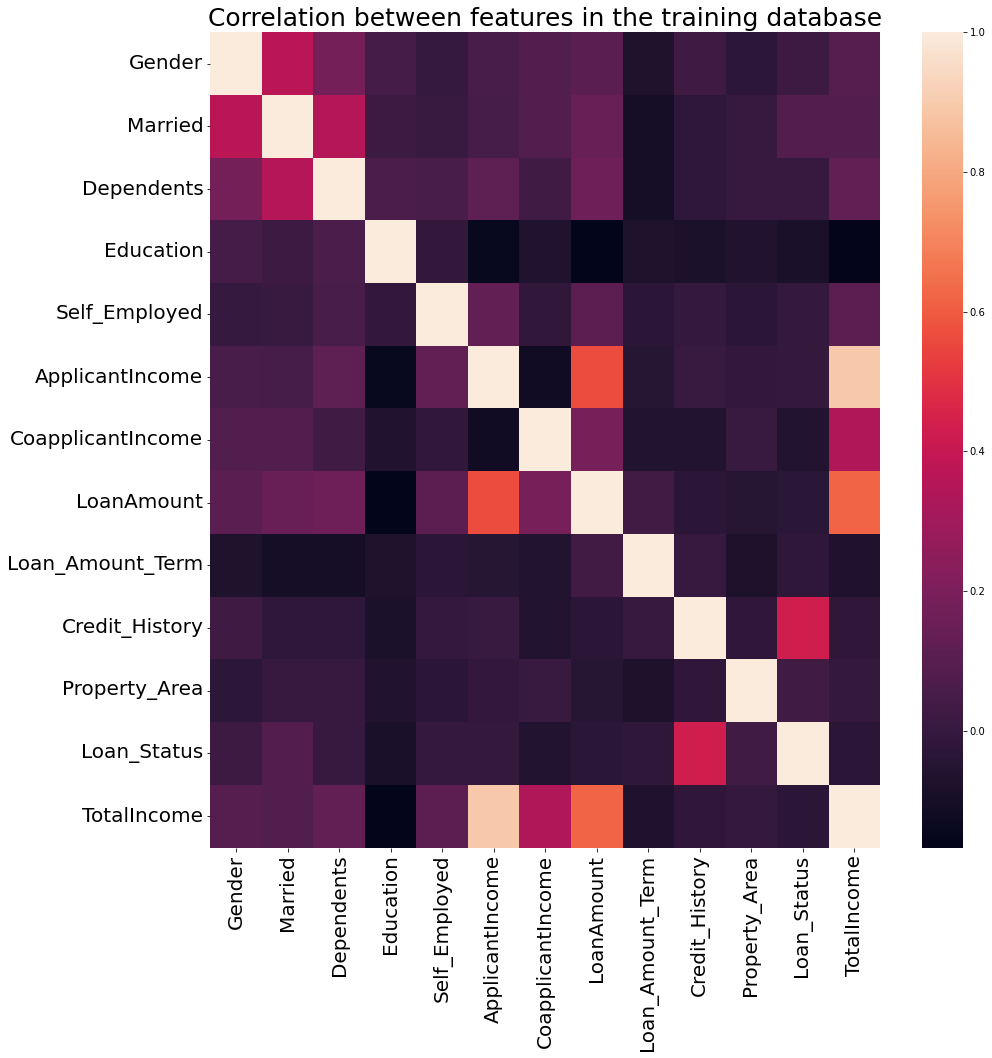

In [30]:
# Generating Heat map of variables

%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 15))
corr = full_data.corr()
ax = sns.heatmap(corr, linecolor='white', cbar=True, annot = False)
ax.set_title("Correlation between features in the training database",fontsize=25);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()

###### Observation: 
There is strong correlation between the loan status and the client's credit history, and between the loan amount and the applicant's income 

##### Generating feature Importance using XGBoost

In [32]:
category_index = [0,1,3,4,10]
for ind in category_index:
    train_data[col_names[ind]] = ler.fit_transform(train_data[col_names[ind]])


#Introduce new feature
train_data['TotalIncome'] = full_data['TotalIncome']

In [33]:
# Feature Scaling
train_data = sc.fit_transform(train_data)
y_target = y_target.reshape(-1, 1)

In [34]:
feature_names= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant Income', 
                'Coapplicant Income', 'Loan Amount','Loan_Amount_Term', 'Credit_History', 
                'Property_Area', 'Total Income']
data_dmatrix = xgb.DMatrix(data=train_data,label=y_target,  feature_names=feature_names)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=100)

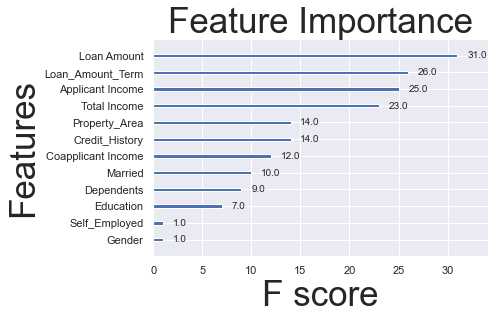

In [424]:
ax = xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 5]
ax.set_ylabel('Features', fontsize=35)
ax.set_xlabel('F score', fontsize=35)
ax.set_title('Feature Importance', fontsize=35)
plt.show()

###### Direction:
At this stage, we'll do away with features with F score less than 10 - Gender, Self_Employed, Education, & Dependents. *See the plot below*. Also, Coapplicant Income and Applicant Income will be droped while the Total Income is retained to avoid duplication.

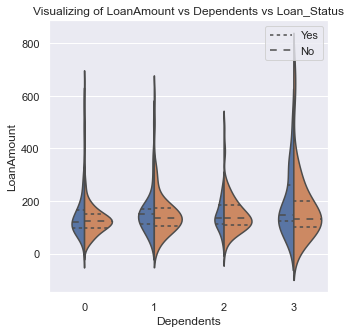

In [430]:
#identifying relationship between Dependents and Loan_Status
%matplotlib inline
sns.set_theme()
#sns.set_theme(style="white")
plt.subplots(figsize=(5, 5))
sns.violinplot(x="Dependents", y="LoanAmount",  hue='Loan_Status', col='Loan_Status', data=full_data, 
                            split=True, scale="count", inner="quartile")
#plt.figure(figsize = (0,0))
#plt.ylim([0, 120])
plt.legend(['Yes','No'])
plt.xticks(rotation = 0)
plt.title("Visualizing of LoanAmount vs Dependents vs Loan_Status" )

plt.show()

###### Relational data, PCA & Kmeans

In [35]:
# Credit History and Loan Status
pd.crosstab(full_data ['Credit_History'], full_data ['Loan_Status'], margins=True)

Loan_Status,0,1,All
Credit_History,,,
0.0,95,44,139
1.0,97,378,475
All,192,422,614


In [36]:
def inert(x,clust_list):
    
    labels = []
    centroids = []
    inerts = []
    
    for clust in clust_list:
        kmeans = KMeans(n_clusters=1,init='k-means++')
        kmeans.fit(x)
        label = kmeans.predict(x)
        centroid = kmeans.cluster_centers_
        inert = kmeans.inertia_
        
        
        labels.append([label])
        centroids.append([centroid])
        inerts.append(inert)
        
    return labels, centroids, inerts


C:\Users\busola\Desktop\771768\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


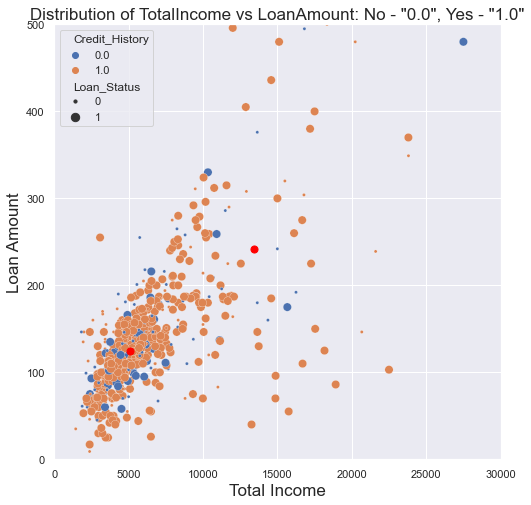

In [428]:
# Focused on applicants granted loan
features = ['TotalIncome', 'LoanAmount']

df2 = full_data[features]

x = full_data.loc[:, features].values

# Starting with K-means
kmeans = KMeans(n_clusters=3,init='k-means++')
kmeans.fit(x)

labels = kmeans.predict(x)
centroids = kmeans.cluster_centers_
labels

fig = plt.figure(figsize=(8,8))
colors = map(lambda x: colmap[x+1], labels)
long = x[:,0]
lat = x[:,1]
sns.scatterplot('TotalIncome', 'LoanAmount', hue = 'Credit_History', size= 'Loan_Status',
    sizes=(70, 10), data = full_data)
plt.ylim(0,500) 
plt.xlim(0,30000 )

plt.scatter(centroids[:,0], centroids[:,1], color='red',  s = 50)
plt.xlabel('Total Income', fontsize = 17 )
plt.ylabel('Loan Amount', fontsize = 17 )
plt.title('Distribution of TotalIncome vs LoanAmount: No - "0.0", Yes - "1.0"', fontsize = 17)
plt.show()

C:\Users\busola\Desktop\771768\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


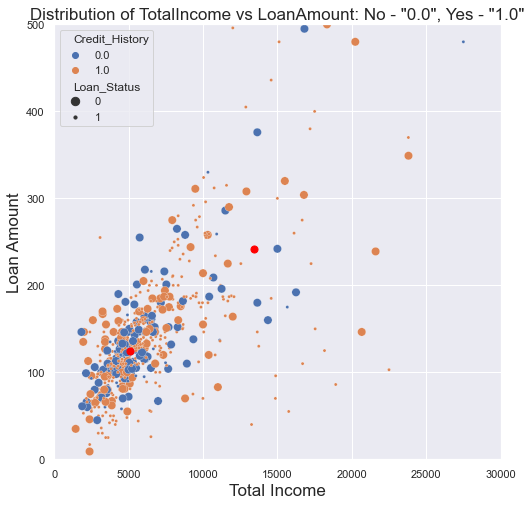

In [429]:
# Focused on rejected applications
features = ['TotalIncome', 'LoanAmount']

df2 = full_data[features]

x = full_data.loc[:, features].values

# Starting with K-means
kmeans = KMeans(n_clusters=3,init='k-means++')
kmeans.fit(x)

labels = kmeans.predict(x)
centroids = kmeans.cluster_centers_
labels

fig = plt.figure(figsize=(8,8))
colors = map(lambda x: colmap[x+1], labels)
long = x[:,0]
lat = x[:,1]
sns.scatterplot('TotalIncome', 'LoanAmount', hue = 'Credit_History', size= 'Loan_Status',
    sizes=(10, 70), data = full_data)
plt.ylim(0,500) 
plt.xlim(0,30000 )

plt.scatter(centroids[:,0], centroids[:,1], color='red',  s = 50)
plt.xlabel('Total Income', fontsize = 17 )
plt.ylabel('Loan Amount', fontsize = 17 )
plt.title('Distribution of TotalIncome vs LoanAmount: No - "0.0", Yes - "1.0"', fontsize = 17)
plt.show()

In [37]:
# Dropping low F score features and others
drop_features = ['Gender', 'Self_Employed', 'Education', 'Dependents', 'CoapplicantIncome', 'ApplicantIncome', 'Loan_Status']
train_data = full_data.copy()
train_data = train_data.drop(columns=drop_features)
train_data = sc.fit_transform(train_data)
train_data[:10]

array([[-1.36228263,  0.        ,  0.2732313 ,  0.54095432,  1.22329839,
        -0.18218376],
       [ 0.73406207, -0.21927331,  0.2732313 ,  0.54095432, -1.31851281,
        -0.14468416],
       [ 0.73406207, -0.957641  ,  0.2732313 ,  0.54095432,  1.22329839,
        -0.62365632],
       [ 0.73406207, -0.31454656,  0.2732313 ,  0.54095432,  1.22329839,
        -0.32288474],
       [-1.36228263, -0.06445428,  0.2732313 ,  0.54095432,  1.22329839,
        -0.15878525],
       [ 0.73406207,  1.4360994 ,  0.2732313 ,  0.54095432,  1.22329839,
         0.40107448],
       [ 0.73406207, -0.61227547,  0.2732313 ,  0.54095432,  1.22329839,
        -0.49209781],
       [ 0.73406207,  0.13800137,  0.2732313 , -1.84858491, -0.04760721,
        -0.23006548],
       [ 0.73406207,  0.25709293,  0.2732313 ,  0.54095432,  1.22329839,
        -0.23130514],
       [ 0.73406207,  2.4126502 ,  0.2732313 ,  0.54095432, -0.04760721,
         2.60084438]])

###### Running K-fold on the dataset

In [38]:
y_target=np.ravel(y_target)  

In [477]:

clf = svm.SVC(kernel='linear', C=1, random_state=42)

n_samples = train_data.shape[0]
cvs = StratifiedKFold(n_splits=5)
scores_s = cross_val_score(clf, train_data, y_target, cv=cvs)
print('cross_val_scores for Stratified KFold:', scores_s)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(clf, train_data, y_target, cv=cv)
print('cross_val_scores for Shuffle Split:', scores)


cross_val_scores for Stratified KFold: [0.80487805 0.7398374  0.72357724 0.78861789 0.79508197]
cross_val_scores for Shuffle Split: [0.78861789 0.77235772 0.74796748 0.76422764 0.78861789]


###### XGBoost without tunning

In [40]:
def model_exec(params):

    # build train and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(train_data, y_target, test_size=0.2)
    
    train_dt = xgb.DMatrix(X_train, label=y_train)
    val_dt = xgb.DMatrix(X_val, label=y_val)

    n_rounds = 100
    early_stopping = 10

    # build the model
    results = {}
    
    model = xgb.train(params, 
                      train_dt, 
                      num_boost_round=20, 
                      evals=[(val_dt, 'val')], 
                      evals_result=results)

    # let’s check how good the model is
    test_data = xgb.DMatrix(X_val)

    predictions = model.predict(test_data)
    
    # Considering the size of the data, the split is limited to train and validation
    accuracy = metrics.accuracy_score(y_val, predictions)

    return accuracy

In [44]:
if __name__ == '__main__':

    default_params = [
        ("num_class", 10), ("eval_metric", "merror")
    ]

    accuracy_result = model_exec(default_params)

    print("accuracy: ", accuracy_result)

[0]	val-merror:0.23577
[1]	val-merror:0.21951
[2]	val-merror:0.22764
[3]	val-merror:0.21951
[4]	val-merror:0.21951
[5]	val-merror:0.21951
[6]	val-merror:0.21951
[7]	val-merror:0.21951
[8]	val-merror:0.21138
[9]	val-merror:0.21951
[10]	val-merror:0.21951
[11]	val-merror:0.21951
[12]	val-merror:0.22764
[13]	val-merror:0.23577
[14]	val-merror:0.24390
[15]	val-merror:0.24390
[16]	val-merror:0.25203
[17]	val-merror:0.24390
[18]	val-merror:0.25203
[19]	val-merror:0.24390
accuracy:  0.7560975609756098


###### XGBoost with hyperparameter tunning (1)

In [41]:
def model_exec_tuning():
    # build train and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(train_data, y_target, test_size=0.2)
    
    train_dt = xgb.DMatrix(X_train, label=y_train)
    val_dt = xgb.DMatrix(X_val, label=y_val)

    params = {'max_depth': [3, 6, 10, 15],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              'n_estimators': [100, 250, 500, 750],
              'num_class': [10]
              }

    xgbclf = xgb.XGBClassifier(objective="multi:softmax", tree_method='hist')
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=25,
                             n_jobs=4,
                             verbose=1)

    clf.fit(X_train, y_train)

    best_combination = clf.best_params_

    return best_combination

In [ ]:
if __name__ == '__main__':

    best_params = model_exec_tuning()

    print("Best hyperparameter combination: ", best_params)

In [45]:
def final_exec1(best_params):

    # build train and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(train_data, y_target, test_size=0.2)
    
    train_dt = xgb.DMatrix(X_train, label=y_train)
    val_dt = xgb.DMatrix(X_val, label=y_val)

    # let’s check how good the model is
    test_data = xgb.DMatrix(X_val)

    num_rounds = 500
    early_stopping = 10

    # Specifying model parameters
    params = best_params
    
    # specify validations set to watch performance
    watchlist = [(val_dt, "eval"), (train_dt, "train")]
    
    #Training the model
    Xbst = xgb.train(params, train_dt, num_boost_round=num_rounds, evals=watchlist)

    # run prediction
    predictions = Xbst.predict(val_dt)
    
    # make prediction
    #predictions = model.predict(test_data)
    
    # dump model
    Xbst.dump_model("Xbest_model.txt")
    
    # save model
    bst.save_model("model-1.json")
    
    # Considering the size of the data, the split is limited to train and validation
    accuracy = metrics.accuracy_score(y_val, predictions)

    return accuracy

In [527]:
params = {'subsample': 0.6, 'num_class': 10, 'n_estimators': 500, 
          'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.7999999999999999,
          'colsample_bylevel': 0.5, "eta": 1}
    
if __name__ == '__main__':

    accuracy_result = final_exec1(params)

    print("accuracy: ", accuracy_result)

[18:52:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:52:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:2.27606	train-mlogloss:2.27508
[1]	eval-mlogloss:2.25122	train-mlogloss:2.24910
[2]	eval-mlogloss:2.22735	train-mlogloss:2.22315
[3]	eval-mlogloss:2.20236	train-mlogloss:2.19759
[4]	eval-mlogloss:2.17570	train-mlogloss:2.17079
[5]	eval-mlogloss:2.1528

[149]	eval-mlogloss:0.93554	train-mlogloss:0.85474
[150]	eval-mlogloss:0.93255	train-mlogloss:0.85122
[151]	eval-mlogloss:0.92946	train-mlogloss:0.84787
[152]	eval-mlogloss:0.92639	train-mlogloss:0.84423
[153]	eval-mlogloss:0.92376	train-mlogloss:0.84088
[154]	eval-mlogloss:0.92098	train-mlogloss:0.83758
[155]	eval-mlogloss:0.91830	train-mlogloss:0.83401
[156]	eval-mlogloss:0.91587	train-mlogloss:0.83069
[157]	eval-mlogloss:0.91315	train-mlogloss:0.82759
[158]	eval-mlogloss:0.91050	train-mlogloss:0.82447
[159]	eval-mlogloss:0.90742	train-mlogloss:0.82125
[160]	eval-mlogloss:0.90462	train-mlogloss:0.81811
[161]	eval-mlogloss:0.90184	train-mlogloss:0.81465
[162]	eval-mlogloss:0.89929	train-mlogloss:0.81147
[163]	eval-mlogloss:0.89664	train-mlogloss:0.80797
[164]	eval-mlogloss:0.89422	train-mlogloss:0.80477
[165]	eval-mlogloss:0.89154	train-mlogloss:0.80149
[166]	eval-mlogloss:0.88882	train-mlogloss:0.79841
[167]	eval-mlogloss:0.88576	train-mlogloss:0.79528
[168]	eval-mlogloss:0.88343	tra

[310]	eval-mlogloss:0.67605	train-mlogloss:0.52769
[311]	eval-mlogloss:0.67541	train-mlogloss:0.52642
[312]	eval-mlogloss:0.67441	train-mlogloss:0.52518
[313]	eval-mlogloss:0.67390	train-mlogloss:0.52407
[314]	eval-mlogloss:0.67339	train-mlogloss:0.52301
[315]	eval-mlogloss:0.67254	train-mlogloss:0.52190
[316]	eval-mlogloss:0.67214	train-mlogloss:0.52088
[317]	eval-mlogloss:0.67139	train-mlogloss:0.51983
[318]	eval-mlogloss:0.67061	train-mlogloss:0.51861
[319]	eval-mlogloss:0.67022	train-mlogloss:0.51760
[320]	eval-mlogloss:0.66955	train-mlogloss:0.51664
[321]	eval-mlogloss:0.66832	train-mlogloss:0.51528
[322]	eval-mlogloss:0.66771	train-mlogloss:0.51418
[323]	eval-mlogloss:0.66697	train-mlogloss:0.51310
[324]	eval-mlogloss:0.66616	train-mlogloss:0.51209
[325]	eval-mlogloss:0.66512	train-mlogloss:0.51103
[326]	eval-mlogloss:0.66438	train-mlogloss:0.51013
[327]	eval-mlogloss:0.66361	train-mlogloss:0.50893
[328]	eval-mlogloss:0.66305	train-mlogloss:0.50797
[329]	eval-mlogloss:0.66258	tra

[471]	eval-mlogloss:0.60835	train-mlogloss:0.40484
[472]	eval-mlogloss:0.60817	train-mlogloss:0.40429
[473]	eval-mlogloss:0.60777	train-mlogloss:0.40355
[474]	eval-mlogloss:0.60744	train-mlogloss:0.40310
[475]	eval-mlogloss:0.60719	train-mlogloss:0.40252
[476]	eval-mlogloss:0.60676	train-mlogloss:0.40210
[477]	eval-mlogloss:0.60643	train-mlogloss:0.40152
[478]	eval-mlogloss:0.60610	train-mlogloss:0.40097
[479]	eval-mlogloss:0.60586	train-mlogloss:0.40045
[480]	eval-mlogloss:0.60554	train-mlogloss:0.39995
[481]	eval-mlogloss:0.60516	train-mlogloss:0.39958
[482]	eval-mlogloss:0.60494	train-mlogloss:0.39924
[483]	eval-mlogloss:0.60476	train-mlogloss:0.39868
[484]	eval-mlogloss:0.60480	train-mlogloss:0.39816
[485]	eval-mlogloss:0.60491	train-mlogloss:0.39762
[486]	eval-mlogloss:0.60487	train-mlogloss:0.39728
[487]	eval-mlogloss:0.60477	train-mlogloss:0.39683
[488]	eval-mlogloss:0.60481	train-mlogloss:0.39638
[489]	eval-mlogloss:0.60465	train-mlogloss:0.39600
[490]	eval-mlogloss:0.60428	tra

###### XGBoost with hyperparameter tunning (2)

In [43]:
def model_exec_tuning():
    # build train and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(train_data, y_target, test_size=0.2)
    
    train_dt = xgb.DMatrix(X_train, label=y_train)
    val_dt = xgb.DMatrix(X_val, label=y_val)

    params = {'max_depth': [3, 6, 10, 15],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              'n_estimators': [100, 250, 500, 750],
              'num_class': [10]
              }

    xgbclf = xgb.XGBClassifier(objective="multi:softmax", tree_method='hist', use_label_encoder=False)
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=25,
                             n_jobs=4,
                             verbose=1)

    clf.fit(X_train, y_train)

    best_combination = clf.best_params_

    return best_combination

In [528]:
params = {'subsample': 0.8999999999999999, 'num_class': 10, 'n_estimators': 100, 
          'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.7,
          'colsample_bylevel': 0.6}

if __name__ == '__main__':

    best_params = model_exec_tuning()

    print("Best hyperparameter combination: ", best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[19:02:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameter combination:  {'subsample': 0.8999999999999999, 'num_class': 10, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6}


In [44]:
def final_exec(best_params):

    # build train and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(train_data, y_target, test_size=0.2)
    
    train_dt = xgb.DMatrix(X_train, label=y_train)
    val_dt = xgb.DMatrix(X_val, label=y_val)

    # let’s check how good the model is
    test_data = xgb.DMatrix(X_val)

    num_rounds = 500
    early_stopping = 10

    # Specifying model parameters
    params = best_params
    
    # specify validations set to watch performance
    watchlist = [(val_dt, "eval"), (train_dt, "train")]
    
    #Training the model
    Xbst2 = xgb.train(params, train_dt, num_boost_round=num_rounds, evals=watchlist)

    # run prediction
    predictions = Xbst.predict(val_dt)
    
    # make prediction
    #predictions = model.predict(test_data)
    
    # dump model
    Xbst2.dump_model("Xbest_model1.txt")
    
    # save model
    Xbst2.save_model("model1.json")
    
    # Considering the size of the data, the split is limited to train and validation
    accuracy = metrics.accuracy_score(y_val, predictions)

    return accuracy

In [535]:
params = {'subsample': 0.8999999999999999, 'num_class': 10, 'n_estimators': 100, 
          'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.7,
          'colsample_bylevel': 0.6}
    
if __name__ == '__main__':

    accuracy_result = final_exec(params)

    print("accuracy: ", accuracy_result)

[19:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:2.27547	train-mlogloss:2.27439
[1]	eval-mlogloss:2.24694	train-mlogloss:2.24490
[2]	eval-mlogloss:2.22061	train-mlogloss:2.21769
[3]	eval-mlogloss:2.19315	train-mlogloss:2.19012
[4]	eval-mlogloss:2.16667	train-mlogloss:2.16334
[5]	eval-mlogloss:2.1420

[149]	eval-mlogloss:0.91859	train-mlogloss:0.81056
[150]	eval-mlogloss:0.91578	train-mlogloss:0.80701
[151]	eval-mlogloss:0.91279	train-mlogloss:0.80363
[152]	eval-mlogloss:0.90975	train-mlogloss:0.79983
[153]	eval-mlogloss:0.90717	train-mlogloss:0.79629
[154]	eval-mlogloss:0.90429	train-mlogloss:0.79276
[155]	eval-mlogloss:0.90113	train-mlogloss:0.78885
[156]	eval-mlogloss:0.89857	train-mlogloss:0.78505
[157]	eval-mlogloss:0.89608	train-mlogloss:0.78150
[158]	eval-mlogloss:0.89365	train-mlogloss:0.77819
[159]	eval-mlogloss:0.89100	train-mlogloss:0.77474
[160]	eval-mlogloss:0.88812	train-mlogloss:0.77177
[161]	eval-mlogloss:0.88538	train-mlogloss:0.76809
[162]	eval-mlogloss:0.88277	train-mlogloss:0.76411
[163]	eval-mlogloss:0.88028	train-mlogloss:0.76061
[164]	eval-mlogloss:0.87775	train-mlogloss:0.75705
[165]	eval-mlogloss:0.87511	train-mlogloss:0.75322
[166]	eval-mlogloss:0.87228	train-mlogloss:0.75016
[167]	eval-mlogloss:0.86978	train-mlogloss:0.74656
[168]	eval-mlogloss:0.86750	tra

[310]	eval-mlogloss:0.67124	train-mlogloss:0.44776
[311]	eval-mlogloss:0.67077	train-mlogloss:0.44619
[312]	eval-mlogloss:0.66999	train-mlogloss:0.44472
[313]	eval-mlogloss:0.66928	train-mlogloss:0.44343
[314]	eval-mlogloss:0.66861	train-mlogloss:0.44230
[315]	eval-mlogloss:0.66804	train-mlogloss:0.44125
[316]	eval-mlogloss:0.66752	train-mlogloss:0.43990
[317]	eval-mlogloss:0.66674	train-mlogloss:0.43852
[318]	eval-mlogloss:0.66600	train-mlogloss:0.43701
[319]	eval-mlogloss:0.66536	train-mlogloss:0.43594
[320]	eval-mlogloss:0.66478	train-mlogloss:0.43482
[321]	eval-mlogloss:0.66439	train-mlogloss:0.43332
[322]	eval-mlogloss:0.66374	train-mlogloss:0.43253
[323]	eval-mlogloss:0.66280	train-mlogloss:0.43132
[324]	eval-mlogloss:0.66218	train-mlogloss:0.43039
[325]	eval-mlogloss:0.66131	train-mlogloss:0.42935
[326]	eval-mlogloss:0.66073	train-mlogloss:0.42793
[327]	eval-mlogloss:0.66008	train-mlogloss:0.42657
[328]	eval-mlogloss:0.65950	train-mlogloss:0.42575
[329]	eval-mlogloss:0.65916	tra

[471]	eval-mlogloss:0.61585	train-mlogloss:0.30360
[472]	eval-mlogloss:0.61576	train-mlogloss:0.30308
[473]	eval-mlogloss:0.61572	train-mlogloss:0.30232
[474]	eval-mlogloss:0.61550	train-mlogloss:0.30171
[475]	eval-mlogloss:0.61548	train-mlogloss:0.30099
[476]	eval-mlogloss:0.61555	train-mlogloss:0.30034
[477]	eval-mlogloss:0.61545	train-mlogloss:0.29975
[478]	eval-mlogloss:0.61541	train-mlogloss:0.29885
[479]	eval-mlogloss:0.61538	train-mlogloss:0.29816
[480]	eval-mlogloss:0.61525	train-mlogloss:0.29744
[481]	eval-mlogloss:0.61517	train-mlogloss:0.29683
[482]	eval-mlogloss:0.61500	train-mlogloss:0.29640
[483]	eval-mlogloss:0.61497	train-mlogloss:0.29550
[484]	eval-mlogloss:0.61514	train-mlogloss:0.29469
[485]	eval-mlogloss:0.61518	train-mlogloss:0.29371
[486]	eval-mlogloss:0.61517	train-mlogloss:0.29307
[487]	eval-mlogloss:0.61508	train-mlogloss:0.29256
[488]	eval-mlogloss:0.61513	train-mlogloss:0.29205
[489]	eval-mlogloss:0.61506	train-mlogloss:0.29173
[490]	eval-mlogloss:0.61510	tra

### Final Results:


| Models             	    | Accuracy                   |
|---------------------------|----------------------------|
| Max_cross validation     :| 0.80                       |
| XGBoost without tunning  :| 0.76                       |
| XGBoost with tunning (1) :| 0.80                       |
| XGBoost with tunning (2) :| 0.75                       |


#### For more on Xboost:
https://xgboost.readthedocs.io/en/stable/get_started.html <br>
https://github.com/dmlc/xgboost/tree/master/demo

## Making predictions from model

In [46]:
# Extracting the test features
copy_test_df['Loan_ID'].to_csv("Loan_ID.csv")
test_datf = copy_test_df.drop(columns=['Loan_ID'], inplace=False)
test_datf.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,0.0,Urban
4,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [47]:
col_names = test_datf.columns
col_names

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [48]:
def postprocess(test_data):
    category_index = [0,1,3,4,10]
    for ind in category_index:
        test_data[col_names[ind]] = ler.fit_transform(test_data[col_names[ind]])
        
    #Introduce new feature
    test_data['TotalIncome'] = test_data['ApplicantIncome'] + test_data['CoapplicantIncome']

    # Dropping low F score features and others
    drop_features = ['Gender', 'Self_Employed', 'Education', 'Dependents', 'CoapplicantIncome', 'ApplicantIncome']
    #test_data = 
    featured_data = test_data.copy().drop(columns=drop_features)
    featured_data = sc.fit_transform(featured_data)
    
    return featured_data
    

In [99]:
# We'll be using the processed test data with XGBOOST
# let’s check how good the model is
import time

print("[INFO] processing test data...")
X_test = postprocess(test_datf)

x_test = xgb.DMatrix(X_test)
    
# save start time
inf_start = time.time()

print("[INFO] Making predictions...")
# run prediction
predictions = Xbst.predict(x_test)

# calculate time from start until now
inf_time = time.time() - inf_start
print('Time taken to make prediction:', inf_time)

# Save the prediction
print("[INFO] Saving the predictions to file...")
pd.DataFrame(predictions).to_csv("my_predictions.csv")

print("[INFO] Operation complete")

[INFO] processing test data...
[INFO] Making predictions...
Time taken to make prediction: 0.003996372222900391
[INFO] Saving the predictions to file...
[INFO] Operation complete
